# Data Analyst & Integrator (Data Science) Take-Home Assignment (#1)

### 3.1 Analysis

In this notebook we will look at the following

1. What are the top 20 ticket infractions (frequency)
2. What are the top 20 ticket infractions (revenue)
4. Total revenue generated from all tickets

* 3.3.1.b Distribution of top 20 infractions by fines

In the interest of saving memory we will work year to year, get the values we want, and then remove the dataframe from memory

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from itertools import groupby
from operator import itemgetter
import seaborn as sns
import csv
import sys
from sklearn.preprocessing import LabelEncoder
import re
%matplotlib inline

It appears that the first three years 2008-2010 have multiple delimeters i.e ',' and '\r\n', as well as varying encodings, when reading this we get an error where the second delimitors are smooshed into the location2 column, the below function is for handling these years

In [2]:
def read_tickets(path, encode='utf-8'):
    pd.options.mode.chained_assignment = None  # default='warn'

    # bad_lines catches errors in formatting
    headers = ["tag_number_masked", "date_of_infraction", "infraction_code", 
               "infraction_description", "set_fine_amount", "time_of_infraction", 
               "location1","location2","location3", "location4", "province", "bad_lines"]

    df = pd.read_csv(path, 
                     encoding=encode,  # not sure why this encoding was used for 08/10 and not other years
                     quotechar='"', 
                     names=headers,
                     low_memory=False)
                     #skiprows=1)

    # there were some error lines condensed into the location2
    bad_lines_df = df[df.bad_lines.notnull()]
    
    corrupt_line_index = bad_lines_df.index[0]
    
    bad_lines_list = bad_lines_df.to_csv(header=None, index=False).strip('\n').split('\r\n')
    bad_lines_df_2 = pd.DataFrame(bad_lines_list)[0].str.split(pat=",", expand=True) 
    
    try:
        bad_lines_df_2.columns = headers
        
        # fixing the last line
        bad_lines_df_2.tail(1)['location2'] = bad_lines_df.tail(1)['location3']
        bad_lines_df_2.tail(1)['location3'] = ''
        bad_lines_df_2.tail(1)['province'] = bad_lines_df.tail(1)['bad_lines']
        # drop last col
        bad_lines_df_2.drop(['bad_lines'], axis=1, inplace=True)
    except ValueError:
        bad_lines_df_2.columns = headers[:-1]
    

    # drop last col
    #bad_lines_df_2.drop(['bad_lines'], axis=1, inplace=True)
    df.drop(['bad_lines'], axis=1, inplace=True)
    df.drop([0, corrupt_line_index], inplace=True)
  
    # stack the two data frames
    df_cleaned = pd.concat([df, bad_lines_df_2]).reset_index(drop=True)
    df_cleaned = df_cleaned.astype({'date_of_infraction': 'int32', 'infraction_code':'int32', 'set_fine_amount':'int32'})

    del df
    del bad_lines_df_2
    return df_cleaned

In [3]:
tickets_2008 = read_tickets('../input/parking-tickets-data/parking-tickets-2008 (1)/Parking_Tags_data_2008.csv', 'UTF-16 LE')
tickets_2008.head(3)

,tag_number_masked,date_of_infraction,infraction_code,infraction_description,set_fine_amount,time_of_infraction,location1,location2,location3,location4,province
0,***63611,20080101,3,PARK/LEAVE ON PRIVATE PROPERTY,30,NaN,NaN,364 EAST MALL,NaN,NaN,ON
1,***99026,20080101,9,STOP HWY PROHIBITED TIME/DAY,60,NaN,NaN,80 RICHMOND ST W,NaN,NaN,ON
2,***63613,20080101,3,PARK/LEAVE ON PRIVATE PROPERTY,30,NaN,NaN,364 EAST MALL,NaN,NaN,ON


We want to clean up these dataframes, especially the location2 field since that is where we are going to be basing most of our analysis on, i.e. to get the most frequent ticketing locations. The below series of helper functions are built to clean up addresses, and remove unwanted punctuation

In [5]:
def remove_punctuation(text, disclude=""):
    from string import punctuation
    
    my_punctuation = punctuation.replace(disclude, "")
    
    # removes the following !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~
    no_punct = "".join([c for c in text if c not in my_punctuation])
    
    # no_punct = re.sub('[0-9]+', '', no_punct)
    
    # remove duplicated spaces and leading / trailing spaces
    no_punct = " ".join(no_punct.split())
    return no_punct

def shorten_rd(address):
    '''Completes the road type. I.e. Rd becomes Road, st becomes Street as per Google etc.'''
    address = address.title()
    address = re.sub(r" Street(?=$| [NE(So|S$)(We|W$)])", ' St', address)
    address = re.sub(r" Road(?=$| [NE(So|S$)(We|W$)])", ' Rd', address)
    address = re.sub(r"(?<!The) Avenue(?=$| [NE(So|S$)(We|W$)])", ' Ave', address)
    address = re.sub(r" Close(?=$| [NE(So|S$)(We|W$)])", ' Cl', address)
    address = re.sub(r" Court(?=$| [NE(So|S$)(We|W$)])", ' Ct', address)
    address = re.sub(r"(?<!The) Crescent(?=$| [NE(So|S$)(We|W$)])", ' Cres', address)
    address = re.sub(r" Boulevarde?(?=$| [NE(So|S$)(We|W$)])", ' Blvd', address)
    address = re.sub(r" Drive(?=$| [NE(So|S$)(We|W$)])", ' Dr', address)
    address = re.sub(r" Lane(?=$| [NE(So|S$)(We|W$)])", ' Ln', address)
    address = re.sub(r" Place(?=$| [NE(So|S$)(We|W$)])", ' Pl', address)
    address = re.sub(r" Square(?=$| [NE(So|S$)(We|W$)])", ' Sq', address)
    address = re.sub(r"(?<!The) Parade(?=$| [NE(So|S$)(We|W$)])", ' Pde', address)
    address = re.sub(r" Circuit(?=$| [NE(So|S$)(We|W$)])", ' Cct', address)
    return address

def lengthen_rd(address):
    address = address.title()
    address = re.sub(r" St(?=$| [NE(So|S$)(We|W$)])", " Street", address)
    address = re.sub(r" Rd(?=$| [NE(So|S$)(We|W$)])", " Road", address)
    address = re.sub(r" Ave(?=$| [NE(So|S$)(We|W$)])", " Avenue", address)
    address = re.sub(r" Av(?=$| [NE(So|S$)(We|W$)])", " Avenue", address)
    address = re.sub(r" Cl(?=$| [NE(So|S$)(We|W$)])", " Close", address)
    address = re.sub(r" Ct(?=$| [NE(So|S$)(We|W$)])", " Court", address)
    address = re.sub(r" Cres(?=$| [NE(So|S$)(We|W$)])", " Crescent", address)
    address = re.sub(r" Blvd(?=$| [NE(So|S$)(We|W$)])", " Boulevard", address)
    address = re.sub(r" Dr(?=$| [NE(So|S$)(We|W$)])", " Drive", address)
    address = re.sub(r" Ln(?=$| [NE(So|S$)(We|W$)])", " Lane", address)
    address = re.sub(r" Pl(?=$| [NE(So|S$)(We|W$)])", " Place", address)
    address = re.sub(r" Sq(?=$| [NE(So|S$)(We|W$)])", " Square", address)
    address = re.sub(r" Pde(?=$| [NE(So|S$)(We|W$)])", " Parade", address)
    address = re.sub(r" Cct(?=$| [NE(So|S$)(We|W$)])", " Circuit", address)
    return address

def standard_addr(address):
    '''Checks for unit numbers and street addresses and puts them in the standard format''' 
    #print("################################")
    #print("### Address: ", address)
    unit_nums = re.findall(r"(?<=Unit )\w?\d+\w?|(?<=U)\d+\w?|\w?\d+\w?(?=\s*/)", address)
    unit_num = unit_nums[0] if len(unit_nums)==1 else ""
    #print("Unit Number: ", unit_num)
    proc_addr = re.sub(r"Unit \w?\d+\w?/?|U\d+\w?/?|\w?\d+\w?\s*/", "", address)
    proc_addr = re.sub(r"^[,\- ]+|[,\- ]+$", "", proc_addr)
    #print("Unitless address: ", proc_addr)
    type_opts = r"Terrace|Way|Walk|St|Rd|Ave|Cl|Ct|Cres|Blvd|Dr|Ln|Pl|Sq|Pde|Cct"
    road_attrs_pattern = r"(?P<rd_no>\w?\d+(\-\d+)?\w?\s+)(?P<rd_nm>[a-zA-z \d\-]+)\s+(?P<rd_tp>" + type_opts + ")"
    #print("Road Attr Pattern: ", road_attrs_pattern)
    road_attrs = re.search(road_attrs_pattern, proc_addr)
    try:
        road_num = road_attrs.group('rd_no').strip()
    except AttributeError:
        road_num = ""
    #print("Road number: ", road_num)
    try:
        road_name = road_attrs.group('rd_nm').strip()
    except AttributeError:
        road_name = ""
    #print("Road name: ", road_name)
    try:
        road_type = road_attrs.group('rd_tp').strip()
    except AttributeError:
        road_type = ""
    #print("Road type: ", road_type)
    proc_addr = lengthen_rd(re.sub(r"^[,\- ]+|[,\- ]+$", "", re.sub(road_attrs_pattern, "", proc_addr)))
    #print("Leftover: ", proc_addr)

    unit_seg = (unit_num + "/" if unit_num!="" else "") if road_num != "" else ("Unit " + unit_num + ", " if unit_num!="" else "")
    road_seg = ((road_num + " " if road_num!="" else "") + road_name + " " + road_type).strip()
    post_road_seg = " " + proc_addr if proc_addr != "" else ""
    proc_addr = (unit_seg + road_seg) + post_road_seg
    #print("### Processed Address: ", proc_addr)
    return proc_addr

In [6]:
# this function keeps track of the number of unique columns before and after the cleaning is run
def cleaning_df_addresses(df, col_name):
    before = df[col_name].nunique()
    
    # clean the addresses, remove punctuation
    df[col_name] = df[col_name].apply(lambda x: remove_punctuation(str(x)))
    
    # lengthen addresses
    df[col_name] = df[col_name].apply(lambda x: lengthen_rd(str(x).upper()))
    
    after = df[col_name].nunique()
    
    return before - after

Below we create some functions to obtian the top 20 for revenue and counts

In [7]:
def top_20_freq(df, col):
    # function to return a df with the top 20 counts
    
    # drop nulls in column
    df = df[df[col].notna()]

    # might want to use this encoding later
    df['count'] = df[[col]].apply(LabelEncoder().fit_transform)

    # get number of tickets per location
    top_20 = df.groupby(col)['count'].count().reset_index()

    # sort
    top_20 = top_20.sort_values(by=['count'], ascending=False).head(20).reset_index(drop=True)
    return top_20

def top_20_rev(df, col_1, col_2):
    # function to return a df with the top 20 revs by col_2
    
    # drop nulls in column
    df = df[df[col_1].notna()]

    # get number of tickets per location
    top_20_rev = df.groupby(col_1)[col_2].sum().reset_index()

    # sort
    top_20_rev = top_20_rev.sort_values(by=[col_2], ascending=False).head(20).reset_index(drop=True)
    return top_20_rev


Note the runtimes of the below could be improved, the cleaning_df_addresses is computation intensive

In [8]:
# call the cleaner
cleaning_df_addresses(tickets_2008, 'location2')

# get the dataframes we want
top_20_freq_08 = top_20_freq(tickets_2008, 'location2')
top_20_rev_08 = top_20_rev(tickets_2008, 'location2', 'set_fine_amount')

# keep a running total of the revenue
total_revenue = tickets_2008['set_fine_amount'].sum()

In [9]:
# call the cleaner
tickets_2009 = read_tickets('../input/parking-tickets-data/parking-tickets-2009/Parking_Tags_data_2009.csv', 'utf-8')
cleaning_df_addresses(tickets_2009, 'location2')

# get the dataframes we want
top_20_freq_09 = top_20_freq(tickets_2009, 'location2')
top_20_rev_09 = top_20_rev(tickets_2009, 'location2', 'set_fine_amount')

# keep a running total of the revenue
total_revenue += tickets_2009['set_fine_amount'].sum()

In [10]:
# call the cleaner
tickets_2010 = read_tickets('../input/parking-tickets-data/parking-tickets-2010/Parking_Tags_data_2010.csv', 'UTF-16 LE')
cleaning_df_addresses(tickets_2010, 'location2')

# get the dataframes we want
top_20_freq_10 = top_20_freq(tickets_2010, 'location2')
top_20_rev_10 = top_20_rev(tickets_2010, 'location2', 'set_fine_amount')

# keep a running total of the revenue
total_revenue += tickets_2010['set_fine_amount'].sum()

In [11]:
# we don't need these in memory anymore
del tickets_2008, tickets_2009, tickets_2010

In [12]:
# Years 2011 through 2020 do not have the multi-delimiter issue,
# we can walk through the directory and get a list of csv files
csvs = []

for path, subdirs, files in os.walk("../input/parking-tickets-data"):
    for name in files:
        if name.lower().endswith('.csv'):
            csvs.append(os.path.join(path, name))

paths = [list(i) for j, i in groupby(csvs,
                  lambda a: a.split('_')[0])]


paths = sorted(paths, key=itemgetter(0))

years = {}  # dictionary to contain the datafames with keys as the year

for i, path in enumerate(paths[3:]):
    key = i+2011
    value = pd.concat((pd.read_csv(f, quotechar='"') for f in path))
    years[key] = value


In [13]:
# store the data sets in a dictionary for ease of access later
top_20_dict = {2008:(top_20_freq_08, top_20_freq_08), 
               2009:(top_20_freq_09, top_20_freq_09),
               2010:(top_20_freq_10, top_20_freq_10)}

# clean each of the datasets for the years 2011 to 2020, also sum the total revenue
for year in range(2011,2021):
    cleaning_df_addresses(years[year], 'location2')
    top_20_dict[year] = (top_20_freq(years[year], 'location2'), top_20_rev(years[year], 'location2', 'set_fine_amount'))
    total_revenue += years[year]['set_fine_amount'].sum()

### 3. Total revenue generated from all tickets

In [48]:
'${:,.0f}'.format(total_revenue)

'$1,371,003,445'

In [16]:
# now we have the top 20 by count and by revenue per year
top_20_dict[2018][1]

,location2,set_fine_amount
0,40 Orchard View Boulevard,383620
1,21 Hillcrest Avenue,317600
2,410 College Street,305735
3,18 Grenville Street,284520
4,1 Brimley Road S,238320
5,20 Edward Street,227470
6,150 Dan Leckie Way,225950
7,2075 Bayview Avenue,187545
8,273 Bloor Street W,183120
9,James Street,150850


In [17]:
top_20_dict[2018][0]

,location2,count
0,2075 Bayview Avenue,6238
1,20 Edward Street,4858
2,1265 Military Trl,3562
3,273 Bloor Street W,3060
4,15 Marine Parade Drive,2983
5,250 Front Street E,2762
6,2200 Lake Shore Boulevard W,2709
7,La Plante Avenue,2708
8,103 The Queensway,2701
9,199 Richmond Street W,2679


In [18]:
# group them all together, so we can have the top overall
top_20 = pd.concat(top_20_dict[year][0] for year in range(2008, 2021)).reset_index(drop=True)

In [19]:
# add up all the counts and sort
top_20 = top_20.groupby('location2')['count'].sum().reset_index()
top_20 = top_20.sort_values(by=['count'], ascending=False).head(20).reset_index(drop=True)

### What are the top 20 ticket infractions (frequency)

In [20]:
top_20

,location2,count
0,2075 Bayview Avenue,111733
1,20 Edward Street,66580
2,1750 Finch Avenue E,52971
3,James Street,36384
4,1265 Military Trl,20638
5,25 The West Mall,19861
6,25 St Mary Street,19538
7,941 Progress Avenue,19469
8,1 Brimley Road S,19162
9,40 Orchard View Boulevard,18938


### 3.3.1.b Distribution of top 20 infractions by fines (count)

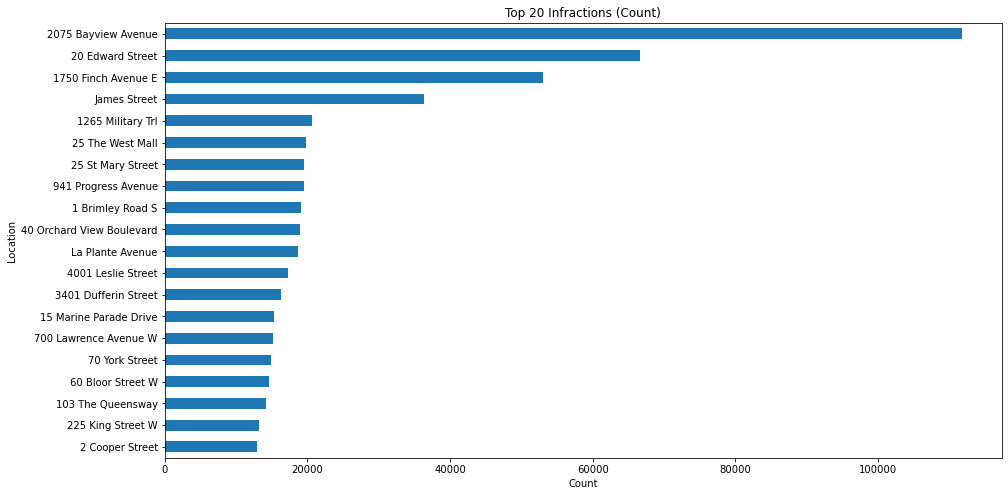

In [52]:
p1 = top_20.plot(x='location2', y='count', kind='barh', legend=False, title='Top 20 Infractions (Count)', figsize=(15,8))
p1.set_xlabel("Count")
p1.set_ylabel("Location")
p1.invert_yaxis();

### Lets do the same for revenue

In [42]:
# group them all together, so we can have the top overall
top_20_revenue = pd.concat(top_20_dict[year][1] for year in range(2008, 2021)).reset_index(drop=True)

In [43]:
# add up all the counts
top_20_revenue['count'] = top_20_revenue['count'].fillna(top_20_revenue['set_fine_amount'])
top_20_revenue.drop('set_fine_amount', inplace=True, axis=1)

In [44]:
top_20_revenue = top_20_revenue.groupby('location2')['count'].sum().reset_index()
top_20_revenue = top_20_revenue.sort_values(by=['count'], ascending=False).head(20).reset_index(drop=True)

## What are the top 20 ticket infractions (revenue)

In [49]:
top_20_revenue.rename({'count': 'revenue'}, axis=1, inplace=True)
pd.options.display.float_format = '${:,.0f}'.format
top_20_revenue

,location2,revenue
0,410 College Street,"$3,124,470"
1,40 Orchard View Boulevard,"$2,665,708"
2,1 Brimley Road S,"$2,584,975"
3,2075 Bayview Avenue,"$2,413,296"
4,18 Grenville Street,"$2,131,720"
5,20 Edward Street,"$1,963,682"
6,1090 Don Mills Road,"$1,676,830"
7,James Street,"$1,590,447"
8,150 Dan Leckie Way,"$1,405,990"
9,21 Hillcrest Avenue,"$1,390,470"


### 3.3.1.b Distribution of top 20 infractions by fines (revenue)

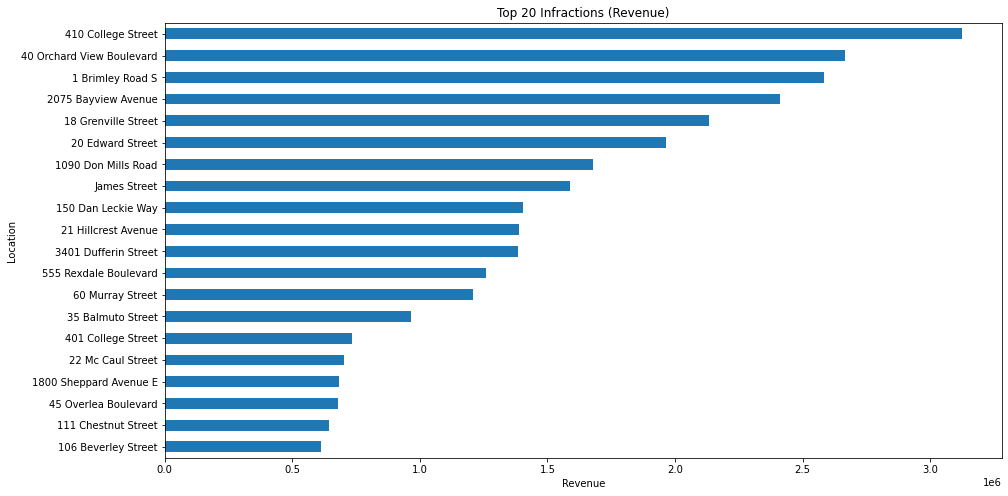

In [53]:
p2 = top_20_revenue.plot(x='location2', y='revenue', kind='barh', legend=False, title='Top 20 Infractions (Revenue)', figsize=(15,8))
p2.set_xlabel("Revenue")
p2.set_ylabel("Location")
p2.invert_yaxis();

In [54]:
# Top 20 ticket infractions (frequency) totals
top_20['count'].sum()

537930

In [56]:
# Top 20 ticket infractions (revenue) totals
'${:,.0f}'.format(top_20_revenue['revenue'].sum())

'$29,827,993'

## Geocoding top locations

In [62]:
# collapse the common values
#top_20_revenue.rename({'revenue': 'count'}, axis=1, inplace=True)
top_locations = pd.concat([top_20, top_20_revenue]).reset_index(drop=True)

In [63]:
top_locations.drop('count', inplace=True, axis=1)
top_locations.drop('revenue', inplace=True, axis=1)

In [64]:
top_locations = top_locations.drop_duplicates().reset_index(drop=True)

In [65]:
# add in a column for the city so we can geocode easier
top_locations['province'] = 'TORONTO, ON'

In [66]:
top_locations.head()

,location2,province
0,2075 Bayview Avenue,"TORONTO, ON"
1,20 Edward Street,"TORONTO, ON"
2,1750 Finch Avenue E,"TORONTO, ON"
3,James Street,"TORONTO, ON"
4,1265 Military Trl,"TORONTO, ON"


In [67]:
# geocode the top 20 locations
from geopy.geocoders import ArcGIS

geolocator = ArcGIS(user_agent="parking_tickets2")
top_locations['city_coord'] = top_locations.apply(lambda x: geolocator.geocode(str(x.location2) + ','+str(x.province)), axis=1)
top_locations

,location2,province,city_coord
0,2075 Bayview Avenue,"TORONTO, ON","(2075 Bayview Ave, North York, Toronto, Ontari..."
1,20 Edward Street,"TORONTO, ON","(20 Edward St, Toronto, Ontario, M5G 1C9, (43...."
2,1750 Finch Avenue E,"TORONTO, ON","(1750 Finch Ave E, North York, Toronto, Ontari..."
3,James Street,"TORONTO, ON","(James St, Toronto, Ontario, M5G, (43.65307234..."
4,1265 Military Trl,"TORONTO, ON","(1265 Military Trl, Scarborough, Toronto, Onta..."
5,25 The West Mall,"TORONTO, ON","(25 The West Mall, Etobicoke, Toronto, Ontario..."
6,25 St Mary Street,"TORONTO, ON","(25 St Mary St, Toronto, Ontario, M4Y 1R2, (43..."
7,941 Progress Avenue,"TORONTO, ON","(941 Progress Ave, Scarborough, Toronto, Ontar..."
8,1 Brimley Road S,"TORONTO, ON","(1 Brimley Rd S, Scarborough, Toronto, Ontario..."
9,40 Orchard View Boulevard,"TORONTO, ON","(40 Orchard View Blvd, Toronto, Ontario, M4R 1..."


In [68]:
top_locations[['address', 'coords']] = pd.DataFrame(top_locations['city_coord'].tolist(), index=top_locations.index)
top_locations[['Latitude', 'Longitude']] = pd.DataFrame(top_locations['coords'].tolist(), index=top_locations.index)

In [69]:
top_locations.head(5)

,location2,province,city_coord,address,coords,Latitude,Longitude
0,2075 Bayview Avenue,"TORONTO, ON","(2075 Bayview Ave, North York, Toronto, Ontari...","2075 Bayview Ave, North York, Toronto, Ontario...","(43.72149001514609, -79.37880999379736)",$44,$-79
1,20 Edward Street,"TORONTO, ON","(20 Edward St, Toronto, Ontario, M5G 1C9, (43....","20 Edward St, Toronto, Ontario, M5G 1C9","(43.65706000181709, -79.38218999625286)",$44,$-79
2,1750 Finch Avenue E,"TORONTO, ON","(1750 Finch Ave E, North York, Toronto, Ontari...","1750 Finch Ave E, North York, Toronto, Ontario...","(43.793940936254224, -79.34940231257131)",$44,$-79
3,James Street,"TORONTO, ON","(James St, Toronto, Ontario, M5G, (43.65307234...","James St, Toronto, Ontario, M5G","(43.65307234392041, -79.38109946360196)",$44,$-79
4,1265 Military Trl,"TORONTO, ON","(1265 Military Trl, Scarborough, Toronto, Onta...","1265 Military Trl, Scarborough, Toronto, Ontar...","(43.78547081980686, -79.18607639029766)",$44,$-79


At this point I decided to store the relevant datasets and begin a new notebook

In [72]:
top_locations.to_csv('top_locations.csv')
top_20.to_csv('top_20_count_total.csv')
top_20_revenue.to_csv('top_20_revenue_total.csv')